In [1]:
from pytorch_direct_warp.direct_warp import DirectWarper
from pytorch_direct_warp.occlusion_mapper import OcclusionMapper
from utils import inverse_warp, pixel2cam, pose_vec2mat, cam2pixel
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc
import matplotlib.colors as colors
from imageio import imread
from skimage.transform import resize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML

device = torch.device("cuda")
torch.no_grad()
plt.rcParams["figure.figsize"] = [12,9]
h=200
f = h/2
batch_size = 1

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('gist_rainbow')
new_cmap = truncate_colormap(cmap, 0, 0.85)

intrinsics = torch.Tensor([[f, 0, h/2],
                           [0, f, h/2],
                           [0,  0,  1]]).float().to(device).unsqueeze(0)
intrinsics_inv = torch.inverse(intrinsics[0]).unsqueeze(0)
pose = torch.Tensor([2/5, 2/5, 0., 0, 0, 0]).unsqueeze(0).to(device).expand(batch_size, 6)

In [3]:

print(intrinsics)
print(intrinsics_inv)
matrix = pose_vec2mat(pose)
print(matrix)
transfer_matrix = intrinsics@torch.cat([matrix[:,:,:3]@intrinsics_inv, matrix[:,:,-1:]], dim=-1)
print(transfer_matrix)


fg_depth = 1
bg_depth = 10

fg_init_pos = [50, 50]

fg_displacement = transfer_matrix[0,:2,-1]/fg_depth
bg_displacement = transfer_matrix[0,:2,-1]/bg_depth

print(fg_displacement, bg_displacement)

tensor([[[100.,   0., 100.],
         [  0., 100., 100.],
         [  0.,   0.,   1.]]], device='cuda:0')
tensor([[[ 0.0100, -0.0000, -1.0000],
         [ 0.0000,  0.0100, -1.0000],
         [ 0.0000,  0.0000,  1.0000]]], device='cuda:0')
tensor([[[1.0000, 0.0000, 0.0000, 0.4000],
         [0.0000, 1.0000, 0.0000, 0.4000],
         [0.0000, 0.0000, 1.0000, 0.0000]]], device='cuda:0')
tensor([[[ 1.,  0.,  0., 40.],
         [ 0.,  1.,  0., 40.],
         [ 0.,  0.,  1.,  0.]]], device='cuda:0')
tensor([40., 40.], device='cuda:0') tensor([4., 4.], device='cuda:0')


/home/cpinard/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/cpinard/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


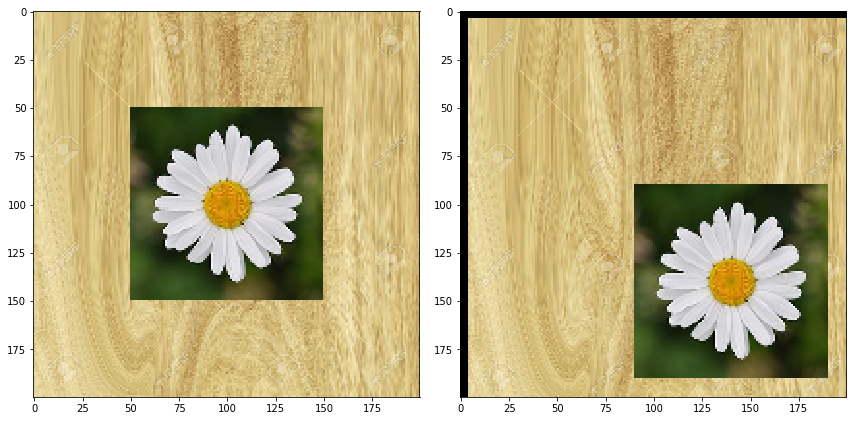

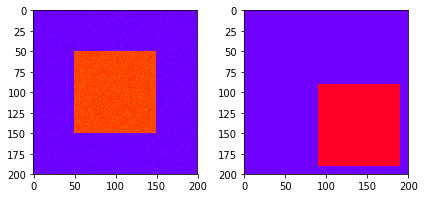

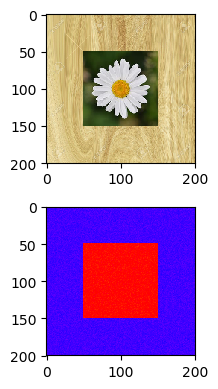

In [5]:
foreground = resize(imread('img/foreground.jpg'), (h//2,h//2))
fg_tensor = torch.from_numpy(foreground.transpose(2,0,1)).float().to(device)
background = resize(imread('img/background.jpg'),(h,h))
bg_tensor = torch.from_numpy(background.transpose(2,0,1)).float().to(device)
img1 = bg_tensor.clone().unsqueeze(0)
temp_h, temp_w = fg_init_pos
img1[:,:, temp_h:temp_h + h//2, temp_w:temp_w + h//2] = fg_tensor
depth1 = (torch.zeros(1,h,h) + bg_depth).float().to(device)
depth1[:, temp_h:temp_h + h//2, temp_w:temp_w + h//2] = fg_depth
depth1 +=  0.1*torch.randn(1,h,h).to(device)
#line = h/2 - torch.linspace(-h/2,h/2,h).abs().to(device)
#parabola = 100/(10 + line.view(1,1,h) + line.view(1,h,1))
#depth1 = parabola

img2 = torch.zeros(1,3,h,h).to(device)
temp_h, temp_w = bg_displacement
img2[:,:, int(temp_h):,int(temp_w):] = bg_tensor.clone()[:,:-int(temp_h), :-int(temp_w)]
temp_h, temp_w = int(fg_init_pos[0] + fg_displacement[0]), int(fg_init_pos[1] + fg_displacement[1])
img2[:,:, temp_h:temp_h + h//2, temp_w:temp_w + h//2] = fg_tensor.unsqueeze(0)
depth2 = (torch.zeros(1,h,h) + bg_depth).float().to(device)
depth2[:, temp_h:temp_h + h//2, temp_h:temp_h + h//2] = 1
plt.figure(figsize=(12,9))
plt.subplot(121)
plt.imshow(img1[0].permute(1,2,0).cpu().numpy())
plt.subplot(122)
plt.imshow(img2[0].permute(1,2,0).cpu().numpy())
plt.tight_layout()
plt.figure()
plt.subplot(121)
plt.imshow(depth1[0].cpu().numpy(), cmap=new_cmap, vmin=0, vmax=10)
plt.subplot(122)
plt.imshow(depth2[0].cpu().numpy(), cmap=new_cmap)
plt.tight_layout()
plt.figure(dpi=100)
plt.subplot(211)
plt.imshow(img1[0].permute(1,2,0).cpu().numpy())
plt.subplot(212)
plt.imshow(depth1[0].cpu().numpy(), cmap=new_cmap)
plt.tight_layout()
plt.show()

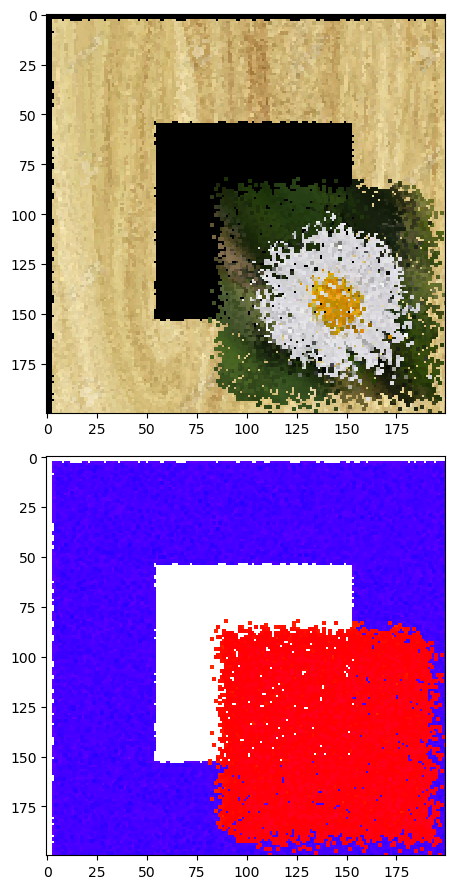

In [6]:
#pose = torch.Tensor([0, -1/5, 0, 0, 0, 0.1]).unsqueeze(0).to(device).expand(batch_size, 6)
matrix = pose_vec2mat(pose)
warper = DirectWarper()
warped, wimg = warper(depth1, img1, matrix, intrinsics, intrinsics_inv, 0)
# warped[:,20:40, 20:40] = warped[:, 20:40,20:40] * 0 + torch.linspace(100,10,20).view(1,1,-1).to(device)
plt.figure(figsize = (12,9), dpi=100)
plt.subplot(211)
plt.imshow(wimg[0].cpu().permute(1,2,0))
plt.subplot(212)
plt.imshow(warped[0].cpu(),cmap=new_cmap)
plt.tight_layout()
plt.show()

torch.Size([200, 200, 3])


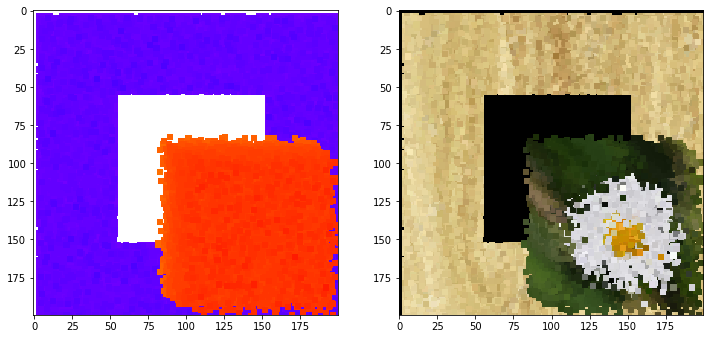

In [7]:
fig = plt.figure(figsize=(12,9))

warped, wimg = warper(depth1, img1, matrix, intrinsics, intrinsics_inv, 1)
warped = warped.cpu()
wimg = wimg[0].permute(1,2,0).cpu()
print(wimg.shape)
plt.subplot(121)
im1 = plt.imshow(warped[0].numpy(), animated=True, vmin=0, vmax=10,cmap=new_cmap)
plt.subplot(122)
im2 = plt.imshow(wimg.numpy(), animated=True)
plt.show()



def animate(i):
    x = np.linspace(0, 2*np.pi, 100)
    pose = torch.Tensor([0*np.sin(x[i]) , 0*np.cos(x[i]), 0.5*np.cos(x[i]), 0.5*np.cos(x[i]), 0, x[i]]).view(1,6).to(device).expand(batch_size, 6)
    pose_mat = pose_vec2mat(pose)
    
    warped, wimg = warper(depth1, img1, pose_mat, intrinsics, intrinsics_inv, 0)
    im1.set_array(warped[0].cpu().numpy())
    im2.set_array(wimg[0].permute(1,2,0).cpu().numpy())
    return (im1,im2)
animate(0)

ani = animation.FuncAnimation(fig, animate, interval=50, blit=True)

HTML(ani.to_html5_video())

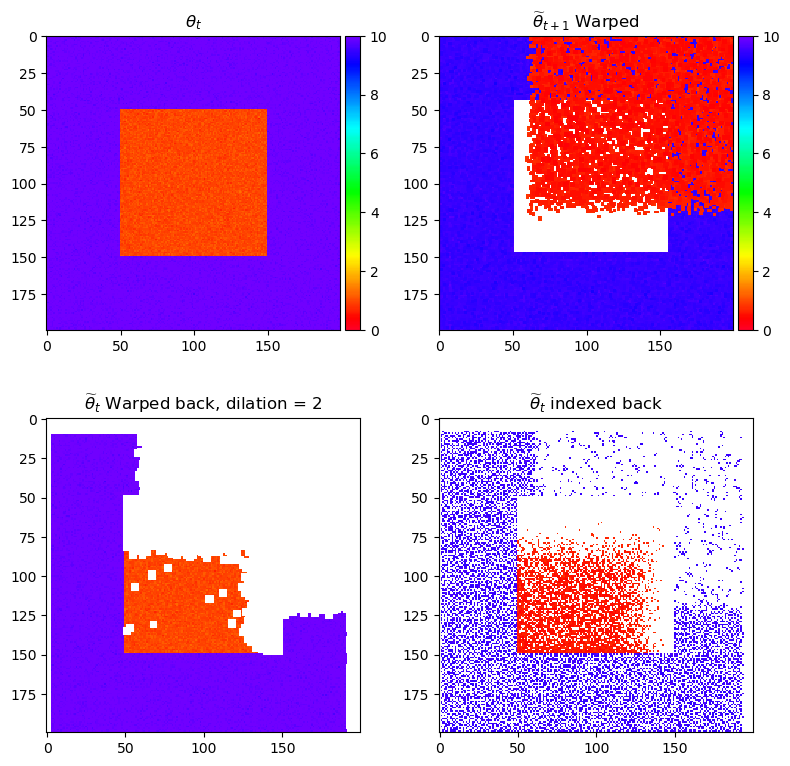

In [8]:
fig = plt.figure(figsize=(8,8), dpi=100)
mapper = OcclusionMapper(dilation=2, alpha = 100)
warped = warper(depth1, None, matrix, intrinsics, intrinsics_inv, 1)
warped = warped.cpu()
ax1 = plt.subplot(221)
im0 = plt.imshow(depth1.cpu().numpy()[0], animated=True, vmin=0, vmax=10,cmap=new_cmap)
plt.title('$\\theta_t$')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')
ax2 = plt.subplot(222)
im1 = plt.imshow(depth1.cpu().numpy()[0], animated=True, vmin=0, vmax=10,cmap=new_cmap)
plt.title('$\widetilde{\\theta}_{t+1}$ Warped')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
plt.subplot(223)
im2 = plt.imshow(warped[0], animated=True, vmin=0, vmax=10,cmap=new_cmap)
plt.title('$\widetilde{\\theta}_t$ Warped back, dilation = $2$')
plt.subplot(224)
im3 = plt.imshow(warped[0], animated=True, vmin=0, vmax=10, cmap=new_cmap)
plt.title('$\widetilde{\\theta}_t$ indexed back')
plt.tight_layout()


x = np.linspace(0, 2*np.pi, 100)

def animate(i):
    pose = torch.Tensor([0.5*np.sin(x[i]) , 0.5*np.cos(x[i]), 0.5*np.cos(x[i]), 0, 0.*np.cos(x[i]), 0.*x[i]]).view(1,6).to(device).expand(batch_size, 6)
    pose_mat = pose_vec2mat(pose)
    inverse_rot = pose_mat[:,:,:3].transpose(1,2)
    inverse_tr = -inverse_rot @ pose_mat[:,:,-1:]
    inverse_matrix = torch.cat([inverse_rot, inverse_tr], dim=-1)

    warped = warper(depth1, None, pose_mat, intrinsics, intrinsics_inv, 0)
    occlusion = mapper(depth1, pose_mat, intrinsics, intrinsics_inv)
    
    depth_occ = depth1.clone()
    depth_occ[occlusion] = float('inf')
    index = warper.index
    
    depth_occ2 = torch.full_like(depth1, float('inf'))
    depth_occ2.view(-1).index_copy_(0, index[index>=0], warped[index>=0])
    
    im1.set_array(warped.cpu().data[0])
    im2.set_array(depth_occ.cpu().data[0])
    im3.set_array(depth_occ2.cpu().data[0])
    return (im1,im2,im3)

animate(40)
plt.show()

ani = animation.FuncAnimation(fig, animate, interval=50, blit=True)

HTML(ani.to_html5_video())